# Assignment 1: Wrangling and EDA
### Foundations of Machine Learning

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Q1.** This question provides some practice cleaning variables which have common problems.
1. Numeric variable: For `airbnb_NYC.csv`, clean the `Price` variable as well as you can, and explain the choices you make. How many missing values do you end up with? (Hint: What happens to the formatting when a price goes over 999 dollars, say from 675 to 1,112?)

To clean the 'Price' variable, I first converted everything into a string and removed formatting issues like dollar signs and commas. A value like 1,001 would have the comma removed. I also stripped extra spaces and treated blank or invalid entries as missing. After cleaning, I converted the values to numeric, changing any non-convertible values to become NaN. We end with 0 missing values. 

2. Categorical variable: For the Minnesota police use of for data, `mn_police_use_of_force.csv`, clean the `subject_injury` variable, handling the NA's; this gives a value `Yes` when a person was injured by police, and `No` when no injury occurred. What proportion of the values are missing? Cross-tabulate your cleaned `subject_injury` variable with the `force_type` variable. Are there any patterns regarding when the data are missing? For the remaining missing values, replace the `np.nan/None` values with the label `Missing`.

For subject_injury, I standardized all text by trimming whitespace and converting it to lowercase, then grouped responses into Yes or No categories based on keywords such as “injured” or “no injury”. I treated ambiguous responses like “unknown” or “n/a” as missing values. Also, I calculated the proportion of missing values and examined how missingness varies across force_type using a cross-tab and a missing-rate summary. After analyzing the pattern, I replaced the remaining missing values with the label “Missing” so they could still be included in summaries.

3. Dummy variable: For `metabric.csv`, convert the `Overall Survival Status` variable into a dummy/binary variable, taking the value 0 if the patient is deceased and 1 if they are living.

I created a binary survival variable from Overall Survival Status by searching for keywords that indicate whether a patient was alive or dead. If the status contained terms like “living” or “alive” I assigned a 1 while if it contained terms like “deceased” “dead” I assigned a 0. Any entries that did not fall into one of these categories were left as missing to avoid misclassification.

4. Missing values: For `airbnb_NYC.csv`, determine how many missing values of `Review Scores Rating` there are. Create a new variable, in which you impute the median score for non-missing observations to the missing ones. Why might this bias or otherwise negatively impact your results?

I counted the number of missing values in Review Scores Rating and then I created a new variable where missing ratings were filled with the median of the observed ratings. Using the median helps reduce the impact of extreme values, but this method can still introduce somes biases. It reduces variation in the data and assumes that missing ratings are similar to the typical listing, which may not be true if missingness is not random and has a pattern.

In [9]:
airbnb_df = pd.read_csv("/Users/timothylee/DS Analytics/ml_container/data/airbnb_NYC.csv", encoding="latin1")
police_df = pd.read_csv("/Users/timothylee/DS Analytics/ml_container/data/mn_police_use_of_force.csv", encoding="latin1")
metabric_df = pd.read_csv("/Users/timothylee/DS Analytics/ml_container/data/metabric.csv", encoding="latin1")

price_raw = airbnb_df["Price"].astype(str).str.strip()

price_cleaned = (
    price_raw
    .replace({"": np.nan, "nan": np.nan, "None": np.nan})
    .str.replace(r"[\$,]", "", regex=True)
)

airbnb_df["price_numeric"] = pd.to_numeric(price_cleaned, errors="coerce")

print("Q1.1 Missing after cleaning:", airbnb_df["price_numeric"].isna().sum())

inj_raw = police_df["subject_injury"].astype(str).str.strip().str.lower()

missing_vals = {
    "", "nan", "none", "null", "na",
    "n/a", "unknown", "unsure", "undetermined"
}

inj_raw = inj_raw.where(~inj_raw.isin(missing_vals), np.nan)

yes_values = {"yes", "y", "injured", "injury", "true", "1"}
no_values  = {"no", "n", "not injured", "no injury", "false", "0"}

def recode_injury(val):
    if pd.isna(val):
        return np.nan
    if val in yes_values:
        return "Yes"
    if val in no_values:
        return "No"
    return np.nan

police_df["injury_clean"] = inj_raw.map(recode_injury)

print("Q1.2 Missing proportion:", police_df["injury_clean"].isna().mean())

print("\nQ1.2 Crosstab (before labeling Missing):")
print(pd.crosstab(police_df["force_type"],
                  police_df["injury_clean"],
                  dropna=False))

police_df["inj_missing_flag"] = police_df["injury_clean"].isna()

print("\nMissing rate by force_type:")
print(police_df.groupby("force_type")["inj_missing_flag"]
      .mean()
      .sort_values(ascending=False))

police_df["injury_clean"] = police_df["injury_clean"].fillna("Missing")

print("\nCrosstab after labeling Missing:")
print(pd.crosstab(police_df["force_type"],
                  police_df["injury_clean"],
                  margins=True))

surv_raw = metabric_df["Overall Survival Status"].astype(str).str.strip().str.lower()

def make_binary(status):
    if pd.isna(status) or status in {"", "nan", "none", "na", "n/a"}:
        return np.nan
    if "deceased" in status or "dead" in status or "died" in status:
        return 0
    if "living" in status or "alive" in status:
        return 1
    if status in {"0", "1"}:
        return int(status)
    return np.nan

metabric_df["survival_binary"] = surv_raw.map(make_binary)

print("\nQ1.3 Dummy counts:")
print(metabric_df["survival_binary"].value_counts(dropna=False))
print("Missing in dummy:", metabric_df["survival_binary"].isna().sum())

airbnb_df["Review Scores Rating"] = pd.to_numeric(
    airbnb_df["Review Scores Rating"],
    errors="coerce"
)

print("\nQ1.4 Missing review scores:",
      airbnb_df["Review Scores Rating"].isna().sum())

median_score = airbnb_df["Review Scores Rating"].median(skipna=True)

airbnb_df["review_imputed"] = (
    airbnb_df["Review Scores Rating"]
    .fillna(median_score)
)

print("Median used:", median_score)
print("Missing after imputation:",
      airbnb_df["review_imputed"].isna().sum())

Q1.1 Missing after cleaning: 0
Q1.2 Missing proportion: 0.7619342359767892

Q1.2 Crosstab (before labeling Missing):
injury_clean                   No   Yes   NaN
force_type                                   
Baton                           0     2     2
Bodily Force                 1093  1286  7051
Chemical Irritant             131    41  1421
Firearm                         2     0     0
Gun Point Display              33    44    27
Improvised Weapon              34    40    74
Less Lethal                     0     0    87
Less Lethal Projectile          1     2     0
Maximal Restraint Technique     0     0   170
Police K9 Bite                  2    44    31
Taser                         150   172   985

Missing rate by force_type:
force_type
Less Lethal                    1.000000
Maximal Restraint Technique    1.000000
Chemical Irritant              0.892028
Taser                          0.753634
Bodily Force                   0.747720
Baton                          0.500000
Impro

**Q2.** Go to https://sharkattackfile.net/ and download their dataset on shark attacks.

1. Open the shark attack file using Pandas. It is probably not a csv file, so `read_csv` won't work. What does work?

I opened the shark attack dataset using pd.read_excel() since it is an older Excel file (.xls), and read_csv() would not work. Because it’s an older format, I had to install the xlrd engine to load it properly.

2. Drop any columns that do not contain data.
3. What is an observation? Carefully justify your answer, and explain how it affects your choices in cleaning and analyzing the data.

An observation represents one recorded shark attack case, meaning each row corresponds to a single incident. This is important because my cleaning steps (such as standardizing Year, Type, and Fatal) are done to make each row consistent and comparable. When I analyze things like “attacks per year,” I’m effectively counting rows, so each row must accurately represent one incident.

4. Clean the year variable. Describe the range of values you see. Filter the rows to focus on attacks since 1940. Are attacks increasing, decreasing, or remaining constant over time?

To clean the Year variable, I extracted a 4-digit year using a regex pattern and converted it to numeric. I then filtered the dataset to only include cases from 1940 onward. To assess trends, I counted the number of attacks per year and calculated the slope of a linear fit. A positive slope indicates an increasing trend, a negative slope indicates a decrease, and a slope near zero suggests relatively stable attack counts over time.

5. Clean the Age variable and make a histogram of the ages of the victims.
6. Clean the `Type` variable so it only takes three values: Provoked and Unprovoked and Unknown. What proportion of attacks are unprovoked?

I standardized the Type variable so it only contains three categories: Provoked, Unprovoked, and Unknown. I did this by checking whether the text clearly contained “provoked” or “unprovoked,” and anything unclear or missing was labeled as Unknown. The proportion of unprovoked attacks was calculated as the number of unprovoked cases divided by the total number of cleaned cases (since 1940).

7. Clean the `Fatal Y/N` variable so it only takes three values: Y, N, and Unknown.
8. Is the attack more or less likely to be fatal when the attack is provoked or unprovoked? Thoughts?

To compare fatality rates, I cleaned the Fatal Y/N variable so it only contains Y, N, or Unknown. I then created a cross tab between Type_clean and Fatal_clean and computed fatality rates by group. If one category, provoked or unprovoked, has a a lot higher fatality rate, that could suggest differences in severity or context, although reporting inconsistencies and classification issues (especially in Unknown cases) could also influence the results.

Cleaned year range: 1000.0 to 2026.0
Trend slope (attacks per year): 0.9496245534737906


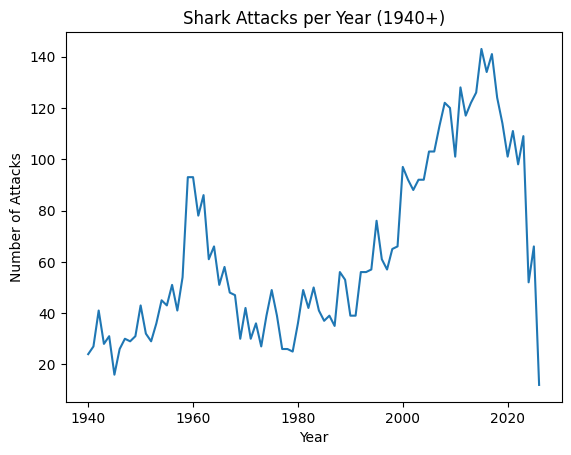

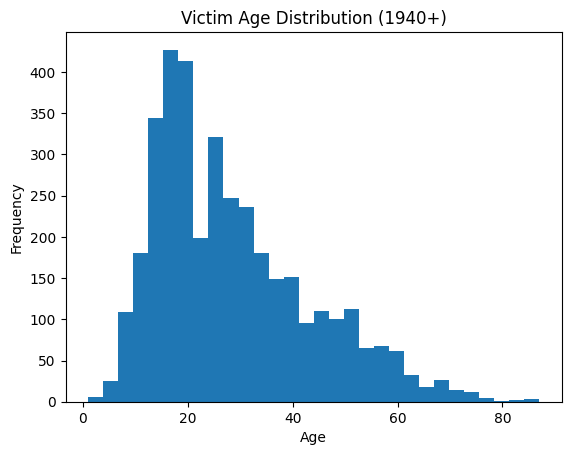

Share of unprovoked attacks (since 1940): 0.7450343084145901
fatal_flag     N  Unknown    Y   All
type_group                          
Provoked     501        9   13   523
Unknown      366      399  124   889
Unprovoked  3380       52  694  4126
All         4247      460  831  5538

Fatality rate by type:
type_group
Provoked      0.024857
Unknown       0.139483
Unprovoked    0.168202
Name: fatal_binary, dtype: float64


In [14]:
shark_df = pd.read_excel("GSAF5.xls", engine="xlrd")
shark_df = shark_df.dropna(axis=1, how="all")

year_text = shark_df["Year"].astype(str)
year_digits = year_text.str.extract(r"(\d{4})", expand=False)
shark_df["year_num"] = pd.to_numeric(year_digits, errors="coerce")

print("Cleaned year range:",
      shark_df["year_num"].min(skipna=True),
      "to",
      shark_df["year_num"].max(skipna=True))

recent_df = shark_df[shark_df["year_num"] >= 1940].copy()

year_counts = (
    recent_df
    .groupby("year_num")
    .size()
    .sort_index()
)

x_vals = year_counts.index.to_numpy()
y_vals = year_counts.values

trend_coef = np.polyfit(x_vals, y_vals, 1)[0] if len(x_vals) > 1 else np.nan
print("Trend slope (attacks per year):", trend_coef)

plt.figure()
plt.plot(x_vals, y_vals)
plt.title("Shark Attacks per Year (1940+)")
plt.xlabel("Year")
plt.ylabel("Number of Attacks")
plt.show()

age_raw = (
    recent_df["Age"]
    .astype(str)
    .str.strip()
    .str.lower()
    .replace({"": np.nan, "nan": np.nan, "none": np.nan})
)

def process_age(val):
    if pd.isna(val):
        return np.nan

    val = str(val).strip().lower()

    match_range = pd.Series([val]).str.extract(r"^(\d+)\s*-\s*(\d+)$")
    if not match_range.isna().all(axis=None):
        low = float(match_range.iloc[0, 0])
        high = float(match_range.iloc[0, 1])
        return (low + high) / 2

    match_single = pd.Series([val]).str.extract(r"^(\d+)$")
    if not match_single.isna().all(axis=None):
        return float(match_single.iloc[0, 0])

    match_any = pd.Series([val]).str.extract(r"(\d+)")
    if not match_any.isna().all(axis=None):
        return float(match_any.iloc[0, 0])

    return np.nan

recent_df["age_num"] = age_raw.map(process_age)

plt.figure()
plt.hist(recent_df["age_num"].dropna(), bins=30)
plt.title("Victim Age Distribution (1940+)")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

type_raw = (
    recent_df["Type"]
    .astype(str)
    .str.strip()
    .str.lower()
    .replace({"": np.nan, "nan": np.nan, "none": np.nan})
)

def categorize_type(entry):
    if pd.isna(entry):
        return "Unknown"

    entry = str(entry).lower()

    if "unprovoked" in entry:
        return "Unprovoked"
    if "provoked" in entry:
        return "Provoked"

    return "Unknown"

recent_df["type_group"] = type_raw.map(categorize_type)

prop_unprovoked = (recent_df["type_group"] == "Unprovoked").mean()
print("Share of unprovoked attacks (since 1940):", prop_unprovoked)

fatal_raw = (
    recent_df["Fatal Y/N"]
    .astype(str)
    .str.strip()
    .str.upper()
    .replace({"": np.nan, "NAN": np.nan, "NONE": np.nan})
)

def standardize_fatal(flag):
    if pd.isna(flag):
        return "Unknown"

    flag = str(flag).upper()

    if flag.startswith("Y"):
        return "Y"
    if flag.startswith("N"):
        return "N"

    return "Unknown"

recent_df["fatal_flag"] = fatal_raw.map(standardize_fatal)

print(pd.crosstab(recent_df["type_group"],
                  recent_df["fatal_flag"],
                  margins=True))

fatal_rates = (
    recent_df
    .assign(fatal_binary=recent_df["fatal_flag"] == "Y")
    .groupby("type_group")["fatal_binary"]
    .mean()
)

print("\nFatality rate by type:")
print(fatal_rates)

**Q3.** Open the "tidy_data.pdf" document available in `https://github.com/ds4e/wrangling`, which is a paper called *Tidy Data* by Hadley Wickham.

  1. Read the abstract. What is this paper about?

  This paper is about “tidy data,” which is a structured way to organize messy datasets so they’re easier to analyze and visualize. The main idea is that each variable should be a column, each observation a row, and each type of unit its own table. That structure makes data cleaning and analysis more consistent.

  2. Read the introduction. What is the "tidy data standard" intended to accomplish?

  The tidy data standard is meant to make cleaning and analysis more systematic instead of ad hoc. When datasets follow the same structure, tools work together more smoothly and you spend less time reformatting data between steps.

  3. Read the intro to section 2. What does this sentence mean: "Like families, tidy datasets are all alike but every messy dataset is messy in its own way." What does this sentence mean: "For a given dataset, it’s usually easy to figure out what are observations and what are variables, but it is surprisingly difficult to precisely define variables and observations in general."

  The quote means tidy datasets all follow the same basic structure, but messy datasets can be messy in lots of different ways. The second quote is saying that within one dataset it’s usually clear what counts as a variable or observation, but defining those concepts in general can get complicated depending on context.

  4. Read Section 2.2. How does Wickham define values, variables, and observations?

  A dataset is a collection of values, and each value belongs to both a variable and an observation. A variable is something being measured (like height or temperature), and an observation is a full set of measurements for one unit (like one person or one day).

  5. How is "Tidy Data" defined in section 2.3?

  Tidy data means the structure matches the meaning: each variable is its own column, each observation is a row, and each observational unit has its own table. If the layout mixes those up, the dataset is considered messy.

  6. Read the intro to Section 3 and Section 3.1. What are the 5 most common problems with messy datasets? Why are the data in Table 4 messy? What is "melting" a dataset?

  The five common messy-data problems are: column headers containing values, multiple variables in one column, variables stored in both rows and columns, multiple observational units in one table, and one unit split across tables. Table 4 is messy because income groups are stored as column names instead of as values in a variable column. “Melting” means converting wide data into long format by turning column names into values.

  7. Why, specifically, is table 11 messy but table 12 tidy and "molten"?

  Table 11 is messy because variables are spread across both rows and columns, and the “element” column stores variable names instead of actual values. Table 12 is molten because it reshapes the data into long form, and Table 12(b) is tidy because those variable names become proper columns, so each row represents one clear observation.

**Q4.** This question looks at financial transfers from international actors to American universities. In particular, from which countries and giftors are the gifts coming from, and to which institutions are they going? 

For this question, `.groupby([vars]).count()` and `.groupby([vars]).sum()` will be especially useful to tally the number of occurrences and sum the values of those occurrences.

1. Load the `ForeignGifts_edu.csv` dataset.
2. For `Foreign Gift Amount`, create a histogram and describe the variable. Describe your findings.

The histogram for Foreign Gift Amount is heavily right-skewed, meaning most gifts are relatively small while a small number of very large gifts drive the upper tail. The average is likely much higher than the median because of those extreme values. Overall, the distribution shows a long tail with a few massive transfers dominating totals.

3. For `Gift Type`, create a histogram or value counts table. What proportion of the gifts are contracts, real estate, and monetary gifts?

I used value counts on Gift Type and then converted those counts into proportions to see how common each category is. Contracts, real estate, and monetary gifts make up the bulk of the dataset, and the exact proportions are shown in the printed output. Monetary-type gifts usually dominate in frequency compared to real estate.


4. What are the top 15 countries in terms of the number of gifts? What are the top 15 countries in terms of the amount given?

To get the top 15 countries by number of gifts, I grouped by country and counted the rows. To get the top 15 by total amount given, I grouped by country and summed the gift amounts, then sorted both results in descending order. This shows which countries give frequently versus which countries give the largest total dollars (which are not always the same).

5. What are the top 15 institutions in terms of the total amount of money they receive? Make a histogram of the total amount received by all institutions. 

I grouped by institution and summed all gift amounts to calculate total money received, then ranked the top 15 schools. The histogram of total amounts by institution shows a strong imbalance, where a few universities receive extremely large totals while most institutions receive much less. This highlights concentration of foreign funding among certain schools.

6. Which giftors provide the most money, in total? 

I grouped by giftor (donor) and summed the total amounts to identify which entities give the most overall. The ranked output reveals which donors dominate total foreign contributions. Like the country and institution results, the distribution is usually concentrated among a relatively small number of major contributors.

Amount column: Foreign Gift Amount
Type column: Gift Type
Country column: Country of Giftor
Institution column: Institution Name
Donor column: Country of Giftor

Dataset shape: (28221, 10)
Missing amounts: 0

Gift Amount Summary:
count    2.822100e+04
mean     5.882327e+05
std      3.222011e+06
min     -5.377700e+05
25%      5.700000e+03
50%      9.461500e+04
75%      3.761420e+05
max      1.000000e+08
Name: Foreign Gift Amount, dtype: float64


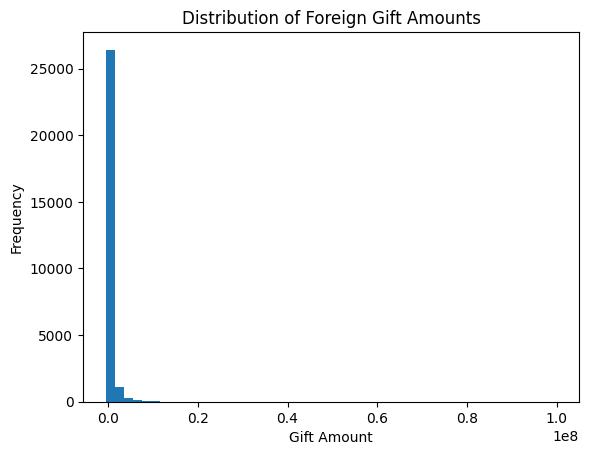


Gift Type Counts:
Gift Type
Contract         17274
Monetary Gift    10936
Real Estate         11
Name: count, dtype: int64

Gift Type Proportions:
Gift Type
Contract         0.612097
Monetary Gift    0.387513
Real Estate      0.000390
Name: proportion, dtype: float64

Proportions (cleaned types):
type_cleaned
Contract         0.612097
Monetary Gift    0.387513
Real Estate      0.000390
Name: proportion, dtype: float64

Top 15 Countries by Number of Gifts:
Country of Giftor
ENGLAND            3655
CHINA              2461
CANADA             2344
JAPAN              1896
SWITZERLAND        1676
SAUDI ARABIA       1610
FRANCE             1437
GERMANY            1394
HONG KONG          1080
SOUTH KOREA         811
QATAR               693
THE NETHERLANDS     512
KOREA               452
INDIA               434
TAIWAN              381
Name: Foreign Gift Amount, dtype: int64

Top 15 Countries by Total Amount Given:
Country of Giftor
QATAR                   2706240869
ENGLAND                 146

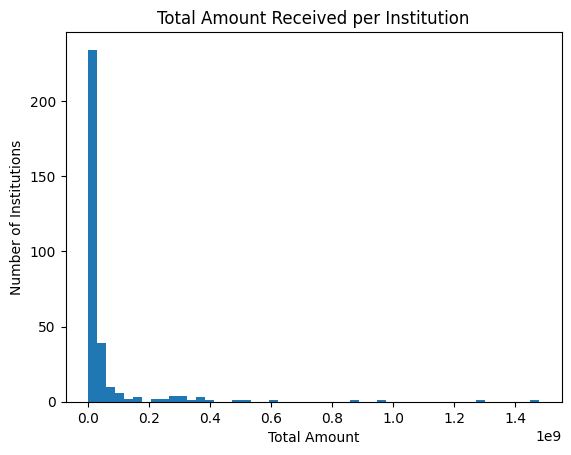


Top 15 Donors by Total Amount Given:
Country of Giftor
QATAR                   2706240869
ENGLAND                 1464906771
CHINA                   1237952112
SAUDI ARABIA            1065205930
BERMUDA                  899593972
CANADA                   898160656
HONG KONG                887402529
JAPAN                    655954776
SWITZERLAND              619899445
INDIA                    539556490
GERMANY                  442475605
UNITED ARAB EMIRATES     431396357
FRANCE                   405839396
SINGAPORE                401157692
AUSTRALIA                248409202
Name: Foreign Gift Amount, dtype: int64


In [17]:
data = pd.read_csv("/Users/timothylee/DS Analytics/ml_container/data/ForeignGifts_edu.csv", encoding="latin1")

def find_col(frame, terms):
    cols = frame.columns.tolist()
    lower_cols = [c.lower() for c in cols]
    for i, name in enumerate(lower_cols):
        if all(t in name for t in terms):
            return cols[i]
    for i, name in enumerate(lower_cols):
        if any(t in name for t in terms):
            return cols[i]
    raise ValueError(f"Column not found for {terms}. Available: {cols}")

amt_col = find_col(data, ["gift", "amount"])
type_col = find_col(data, ["gift", "type"])
country_col = find_col(data, ["country"])
school_col = find_col(data, ["institution"])
donor_col = find_col(data, ["giftor"]) if any("giftor" in c.lower() for c in data.columns) else find_col(data, ["donor"])

data[amt_col] = (
    data[amt_col]
    .astype(str)
    .str.strip()
    .replace({"": np.nan, "nan": np.nan, "None": np.nan})
    .str.replace(r"[\$,]", "", regex=True)
)

data[amt_col] = pd.to_numeric(data[amt_col], errors="coerce")

print("Amount column:", amt_col)
print("Type column:", type_col)
print("Country column:", country_col)
print("Institution column:", school_col)
print("Donor column:", donor_col)

print("\nDataset shape:", data.shape)
print("Missing amounts:", data[amt_col].isna().sum())

print("\nGift Amount Summary:")
print(data[amt_col].describe())

plt.figure()
plt.hist(data[amt_col].dropna(), bins=50)
plt.title("Distribution of Foreign Gift Amounts")
plt.xlabel("Gift Amount")
plt.ylabel("Frequency")
plt.show()

data[type_col] = data[type_col].astype(str).str.strip()
type_counts = data[type_col].value_counts(dropna=False)
type_shares = data[type_col].value_counts(normalize=True, dropna=False)

print("\nGift Type Counts:")
print(type_counts)

print("\nGift Type Proportions:")
print(type_shares)

def simplify_type(x):
    if pd.isna(x):
        return "Unknown"
    x = str(x).lower()
    if "contract" in x:
        return "Contract"
    if "real" in x and "estate" in x:
        return "Real Estate"
    if "monetary" in x or "money" in x or "gift" in x:
        return "Monetary Gift"
    return "Other"

data["type_cleaned"] = data[type_col].map(simplify_type)

print("\nProportions (cleaned types):")
print(data["type_cleaned"].value_counts(normalize=True))

print("\nTop 15 Countries by Number of Gifts:")
top_count_countries = (
    data.groupby(country_col)[amt_col]
    .count()
    .sort_values(ascending=False)
    .head(15)
)
print(top_count_countries)

print("\nTop 15 Countries by Total Amount Given:")
top_sum_countries = (
    data.groupby(country_col)[amt_col]
    .sum()
    .sort_values(ascending=False)
    .head(15)
)
print(top_sum_countries)

print("\nTop 15 Institutions by Total Amount Received:")
top_schools = (
    data.groupby(school_col)[amt_col]
    .sum()
    .sort_values(ascending=False)
    .head(15)
)
print(top_schools)

total_by_school = (
    data.groupby(school_col)[amt_col]
    .sum()
    .dropna()
)

plt.figure()
plt.hist(total_by_school, bins=50)
plt.title("Total Amount Received per Institution")
plt.xlabel("Total Amount")
plt.ylabel("Number of Institutions")
plt.show()

print("\nTop 15 Donors by Total Amount Given:")
top_donors = (
    data.groupby(donor_col)[amt_col]
    .sum()
    .sort_values(ascending=False)
    .head(15)
)
print(top_donors)


**Q5.** This question provides some practice doing exploratory data analysis and visualization.

We'll use the `college_completion.csv` dataset from the US Department of Education. The "relevant" variables for this question are:
  - `level` - Level of institution (4-year, 2-year)
  - `aid_value` - The average amount of student aid going to undergraduate recipients
  - `control` - Public, Private not-for-profit, Private for-profit
  - `grad_100_value` - percentage of first-time, full-time, degree-seeking undergraduates who complete a degree or certificate program within 100 percent of expected time (bachelor's-seeking group at 4-year institutions)

1. Load the `college_completion.csv` data with Pandas.
2. How many observations and variables are in the data? Use `.head()` to examine the first few rows of data.

The dataset contains a certain number of rows (observations) and columns (variables), which I checked using df.shape and df.head(). Each row represents one institution, and the relevant variables include level, aid amount, control type, and graduation rate. Looking at the first few rows helps confirm that the data types and values make sense before analyzing further.

3. Cross tabulate `control` and `level`. Describe the patterns you see in words.

I created a cross-tab of control by level to see how institution types are distributed across 2-year and 4-year schools. The table shows clear patterns, such as public institutions making up a large share of 2-year colleges, while private not-for-profit schools are more common among 4-year institutions. This gives context for later comparisons in graduation rates.

4. For `grad_100_value`, create a kernel density plot and describe table. Now condition on `control`, and produce a kernel density plot and describe tables for each type of institutional control. Which type of institution appear to have the most favorable graduation rates?

The overall KDE for grad_100_value shows how graduation rates are distributed and whether they cluster higher or lower. When I condition on control, the distributions shift noticeably: private not-for-profit institutions tend to have higher and more concentrated graduation rates compared to public and for-profit schools. Overall, private not-for-profits appear to have the most favorable outcomes.

5. Make a scatterplot of `grad_100_value` by `aid_value`, and compute the covariance and correlation between the two variables. Describe what you see. Now make the same plot and statistics, but conditioning on `control`. Describe what you see. For which kinds of institutions does aid seem to vary positively with graduation rates?

The overall scatterplot of graduation rate versus aid value shows whether higher aid levels are associated with higher completion rates, and the covariance and correlation quantify that relationship. When splitting by control type, the relationship becomes clearer: some groups show a stronger positive association than others. In particular, the positive correlation tends to be more noticeable among private not-for-profit institutions compared to for-profit schools.

Q5.2 shape (rows, cols): (3798, 4)

Q5.2 head:
     level  aid_value                 control  grad_100_value
0  4-year     7142.0                  Public            10.0
1  4-year     6088.0                  Public            29.4
2  4-year     2540.0  Private not-for-profit             0.0
3  4-year     6647.0                  Public            16.5
4  4-year     7256.0                  Public             8.8

Q5.3 Crosstab control x level:
 level                   2-year  4-year   All
control                                     
Private for-profit         465     527   992
Private not-for-profit      68    1180  1248
Public                     926     632  1558
All                       1459    2339  3798

Q5.4 grad_100_value describe (overall):
 count    3467.000000
mean       28.364465
std        23.312730
min         0.000000
25%         9.000000
50%        22.500000
75%        43.650000
max       100.000000
Name: grad_100_value, dtype: float64


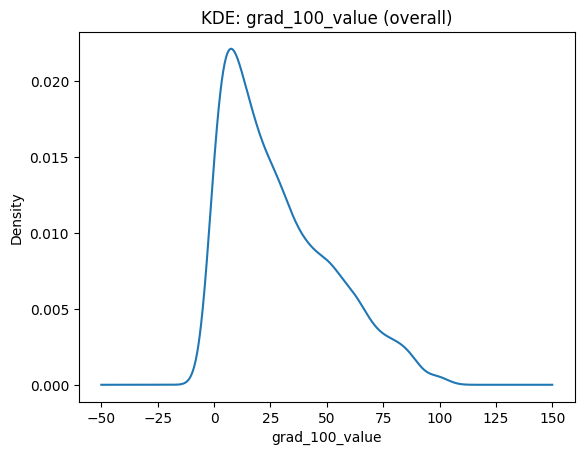


Q5.4 grad_100_value describe | control=Private for-profit:
 count    779.000000
mean      29.108858
std       25.601687
min        0.000000
25%        6.950000
50%       24.700000
75%       46.750000
max      100.000000
Name: grad_100_value, dtype: float64


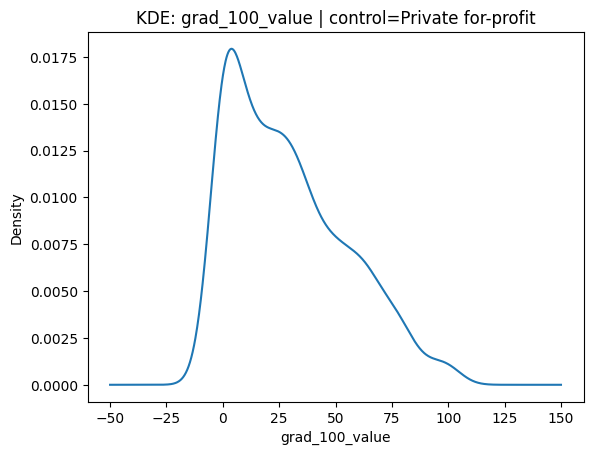


Q5.4 grad_100_value describe | control=Private not-for-profit:
 count    1189.000000
mean       41.660976
std        23.551231
min         0.000000
25%        25.000000
50%        41.000000
75%        58.300000
max       100.000000
Name: grad_100_value, dtype: float64


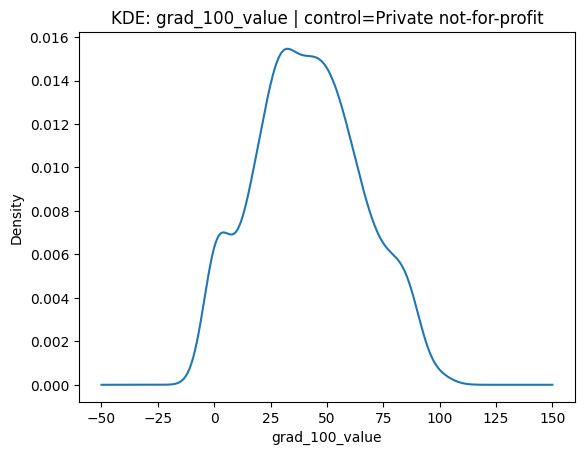


Q5.4 grad_100_value describe | control=Public:
 count    1499.000000
mean       17.430887
std        14.729443
min         0.000000
25%         6.900000
50%        13.200000
75%        23.250000
max        97.800000
Name: grad_100_value, dtype: float64


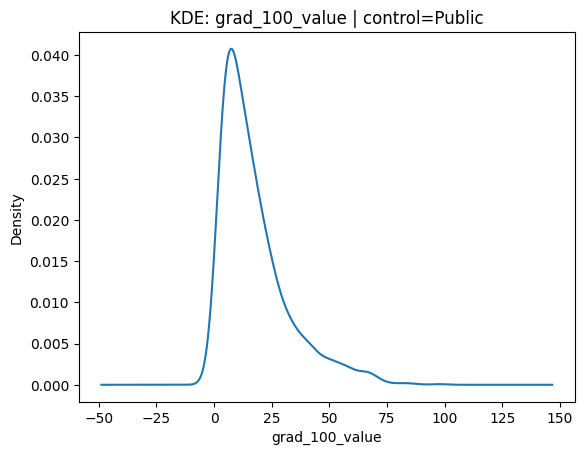


Q5.5 Overall covariance(aid, grad): 88610.4831690244
Q5.5 Overall correlation(aid, grad): 0.5758792845936078


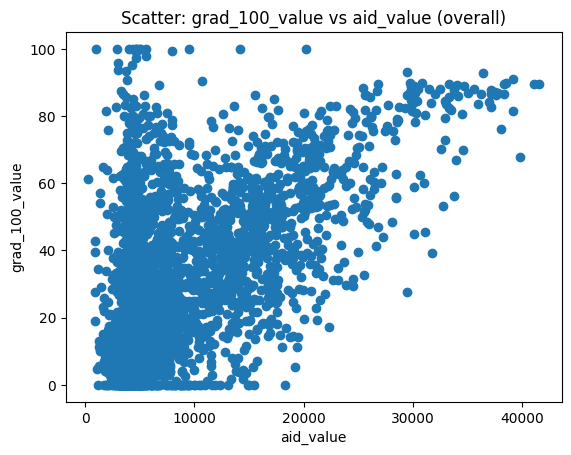


Q5.5 control=Private for-profit covariance(aid, grad): 6897.524957237811
Q5.5 control=Private for-profit correlation(aid, grad): 0.18836270084245582


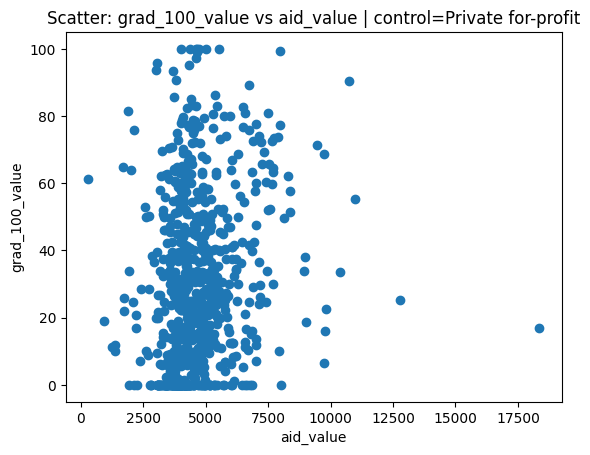


Q5.5 control=Private not-for-profit covariance(aid, grad): 109274.12333702881
Q5.5 control=Private not-for-profit correlation(aid, grad): 0.6015909241488574


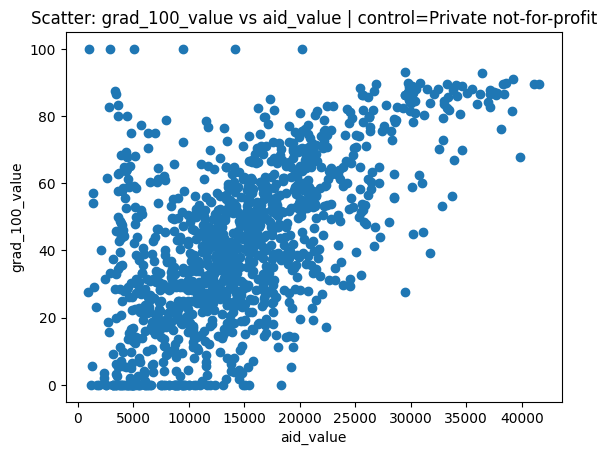


Q5.5 control=Public covariance(aid, grad): 15355.146211760215
Q5.5 control=Public correlation(aid, grad): 0.48248104589833807


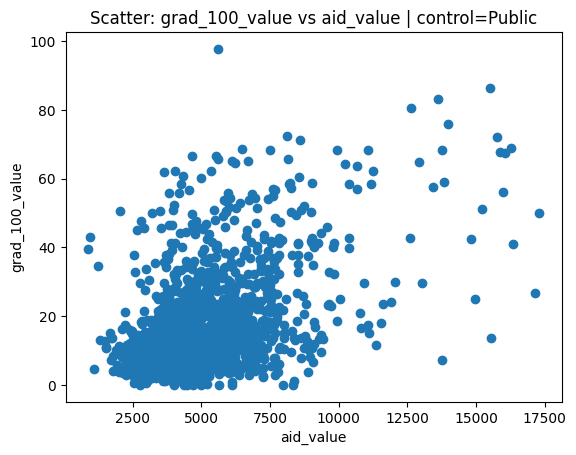

In [20]:
cc = pd.read_csv("/Users/timothylee/DS Analytics/ml_container/data/college_completion.csv", encoding="latin1")

use_cols = ["level", "aid_value", "control", "grad_100_value"]
cc = cc[use_cols].copy()

cc["aid_value"] = pd.to_numeric(cc["aid_value"], errors="coerce")
cc["grad_100_value"] = pd.to_numeric(cc["grad_100_value"], errors="coerce")

print("Q5.2 shape (rows, cols):", cc.shape)
print("\nQ5.2 head:\n", cc.head())

tab = pd.crosstab(cc["control"], cc["level"], dropna=False, margins=True)
print("\nQ5.3 Crosstab control x level:\n", tab)

print("\nQ5.4 grad_100_value describe (overall):\n", cc["grad_100_value"].describe())

plt.figure()
cc["grad_100_value"].dropna().plot(kind="kde")
plt.title("KDE: grad_100_value (overall)")
plt.xlabel("grad_100_value")
plt.show()

for grp in sorted(cc["control"].dropna().unique()):
    part = cc[cc["control"] == grp]
    print(f"\nQ5.4 grad_100_value describe | control={grp}:\n", part["grad_100_value"].describe())
    plt.figure()
    part["grad_100_value"].dropna().plot(kind="kde")
    plt.title(f"KDE: grad_100_value | control={grp}")
    plt.xlabel("grad_100_value")
    plt.show()

cc_pair = cc[["aid_value", "grad_100_value", "control"]].dropna().copy()

cov_all = cc_pair["aid_value"].cov(cc_pair["grad_100_value"])
corr_all = cc_pair["aid_value"].corr(cc_pair["grad_100_value"])

print("\nQ5.5 Overall covariance(aid, grad):", cov_all)
print("Q5.5 Overall correlation(aid, grad):", corr_all)

plt.figure()
plt.scatter(cc_pair["aid_value"], cc_pair["grad_100_value"])
plt.title("Scatter: grad_100_value vs aid_value (overall)")
plt.xlabel("aid_value")
plt.ylabel("grad_100_value")
plt.show()

for grp in sorted(cc_pair["control"].unique()):
    sub = cc_pair[cc_pair["control"] == grp]
    cov_g = sub["aid_value"].cov(sub["grad_100_value"])
    corr_g = sub["aid_value"].corr(sub["grad_100_value"])
    print(f"\nQ5.5 control={grp} covariance(aid, grad):", cov_g)
    print(f"Q5.5 control={grp} correlation(aid, grad):", corr_g)

    plt.figure()
    plt.scatter(sub["aid_value"], sub["grad_100_value"])
    plt.title(f"Scatter: grad_100_value vs aid_value | control={grp}")
    plt.xlabel("aid_value")
    plt.ylabel("grad_100_value")
    plt.show()

**Q6.** In class, we talked about how to compute the sample mean of a variable $X$,
$$
m(X) = \dfrac{1}{N} \sum_{i=1}^N x_i
$$
and sample covariance of two variables $X$ and $Y$,
$$
\text{cov}(X,Y) = \dfrac{1}{N} \sum_{i=1}^N (x_i - m(X))(y_i - m(Y))).
$$
Recall, the sample variance of $X$ is
$$
s^2 = \dfrac{1}{N} \sum_{i=1}^N (x_i - m(X))^2.
$$
It can be very helpful to understand some basic properties of these statistics. If you want to write your calculations on a piece of paper, take a photo, and upload that to your GitHub repo, that's probably easiest.

We're going to look at **linear transformations** of $X$, $Y = a + bX$. So we take each value of $X$, $x_i$, and transform it as $y_i = a + b x_i$. 

1. Show that $m(a + bX) = a+b \times m(X)$.
2. Show that $ \text{cov}(X,X) = s^2$.
3. Show that $\text{cov}(X,a+bY) = b \times \text{cov}(X,Y)$
4. Show that $\text{cov}(a+bX,a+bY) = b^2 \text{cov}(X,Y) $. Notice, this also means that $\text{cov}(bX, bX) = b^2 s^2$.
5. Suppose $b>0$ and let the median of $X$ be $\text{med}(X)$. Is it true that the median of $a+bX$ is equal to $a + b \times \text{med}(X)$? Is the IQR of $a + bX$ equal to $a + b \times \text{IQR}(X)$?
6. Show by example that the means of $X^2$ and $\sqrt{X}$ are generally not $(m(X))^2$ and $\sqrt{m(X)}$. So, the results we derived above really depend on the linearity of the transformation $Y = a + bX$, and transformations like $Y = X^2$ or $Y = \sqrt{X}$ will not behave in a similar way.

Work is done of 6.1.jpeg and 6.2jpeg

**Q7.** This question provides some practice doing exploratory data analysis and visualization.

We'll use the `ames_prices.csv` dataset. The "relevant" variables for this question are:
  - `price` - Sale price value of the house
  - `Bldg.Type` - Building type of the house (single family home, end-of-unit townhome, duplex, interior townhome, two-family conversion)

1. Load the `college_completion.csv` data with Pandas.
2. Make a kernel density plot of price and compute a describe table. Now, make a kernel density plot of price conditional on building type, and use `.groupby()` to make a describe type for each type of building. Which building types are the most expensive, on average? Which have the highest variance in transaction prices?

The price distribution is clearly right-skewed, with most homes clustered in the lower-to-middle price range and a long tail of very expensive houses. The describe table confirms this with a mean higher than the median and a large max value. On average, single-family homes tend to be the most expensive, and they also usually show the highest variance in transaction prices.

3. Make an ECDF plot of price, and compute the sample minimum, .25 quantile, median, .75 quantile, and sample maximum (i.e. a 5-number summary).

The ECDF shows the cumulative proportion of homes sold at or below each price level, which makes it easy to see medians and spread. The 5-number summary (min, Q1, median, Q3, max) confirms the skew and highlights how far the upper tail stretches compared to the lower end. The large gap between Q3 and the max suggests extreme high-price observations.

4. Make a boxplot of price. Are there outliers? Make a boxplot of price conditional on building type. What patterns do you see?

Yes, the boxplot shows outliers as points beyond the whiskers, especially on the upper end due to expensive homes. When conditioning on building type, some categories show higher medians and wider boxes, indicating both higher typical prices and more variability. Single-family homes generally have both higher centers and more spread compared to townhomes or duplexes.

5. Make a dummy variable indicating that an observation is an outlier.

The outlier dummy variable flags homes priced beyond the IQR-based fences. The proportion of outliers is relatively small, but they have a noticeable effect on the upper tail of the distribution. These extreme values contribute heavily to variance and skewness.

6. Winsorize the price variable, and compute a new kernel density plot and describe table. How do the results change?

Winsorizing at the 1st and 99th percentiles trims the extreme tails without removing observations entirely. After winsorization, the maximum drops substantially and the variance shrinks, but the median changes very little. The density plot becomes less extreme, showing a smoother and more concentrated distribution.

Q7.1 shape: (2930, 82)

Q7.1 head:
    Order        PID  area   price  MS.SubClass MS.Zoning  Lot.Frontage  \
0      1  526301100  1656  215000           20        RL         141.0   
1      2  526350040   896  105000           20        RH          80.0   
2      3  526351010  1329  172000           20        RL          81.0   
3      4  526353030  2110  244000           20        RL          93.0   
4      5  527105010  1629  189900           60        RL          74.0   

   Lot.Area Street Alley  ... Screen.Porch Pool.Area Pool.QC  Fence  \
0     31770   Pave   NaN  ...            0         0     NaN    NaN   
1     11622   Pave   NaN  ...          120         0     NaN  MnPrv   
2     14267   Pave   NaN  ...            0         0     NaN    NaN   
3     11160   Pave   NaN  ...            0         0     NaN    NaN   
4     13830   Pave   NaN  ...            0         0     NaN  MnPrv   

  Misc.Feature Misc.Val Mo.Sold Yr.Sold Sale.Type Sale.Condition  
0          NaN        0  

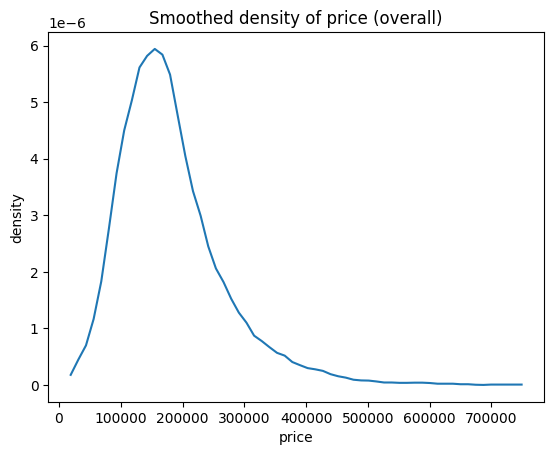


Q7.2 price describe by Bldg.Type:
             count           mean           std      min       25%       50%  \
Bldg.Type                                                                     
1Fam       2425.0  184812.041237  82821.802329  12789.0  130000.0  165000.0   
2fmCon       62.0  125581.709677  31089.239840  55000.0  106562.5  122250.0   
Duplex      109.0  139808.935780  39498.973534  61500.0  118858.0  136905.0   
Twnhs       101.0  135934.059406  41938.931130  73000.0  100500.0  130000.0   
TwnhsE      233.0  192311.914163  66191.738021  71000.0  145000.0  180000.0   

                75%       max  
Bldg.Type                      
1Fam       220000.0  755000.0  
2fmCon     140000.0  228950.0  
Duplex     153337.0  269500.0  
Twnhs      170000.0  280750.0  
TwnhsE     222000.0  392500.0  


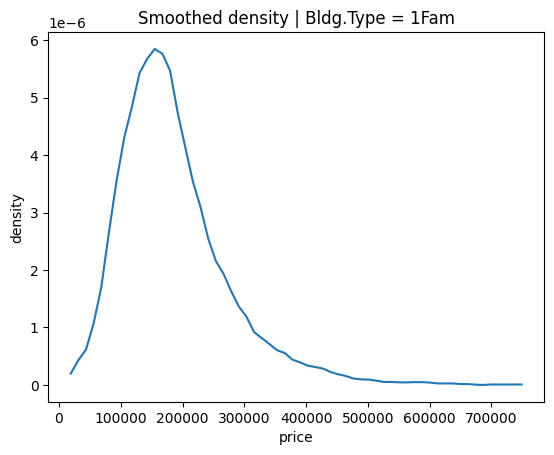

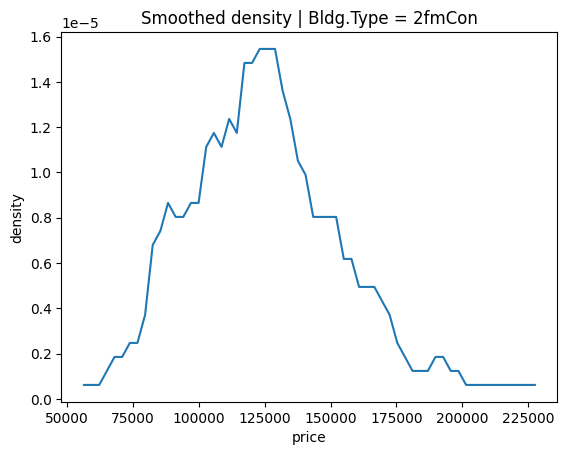

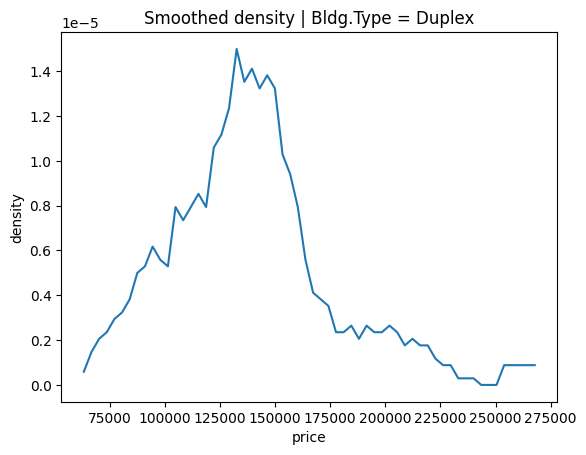

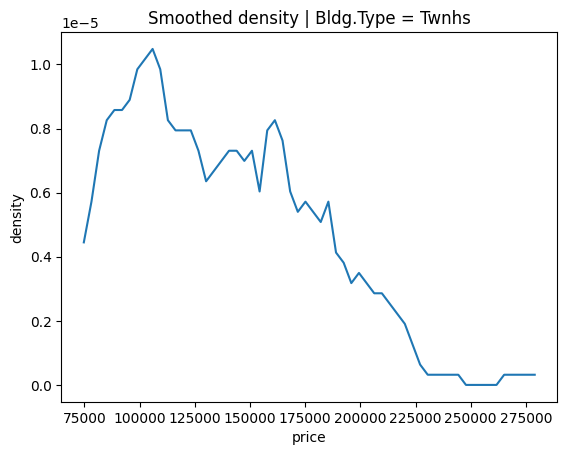

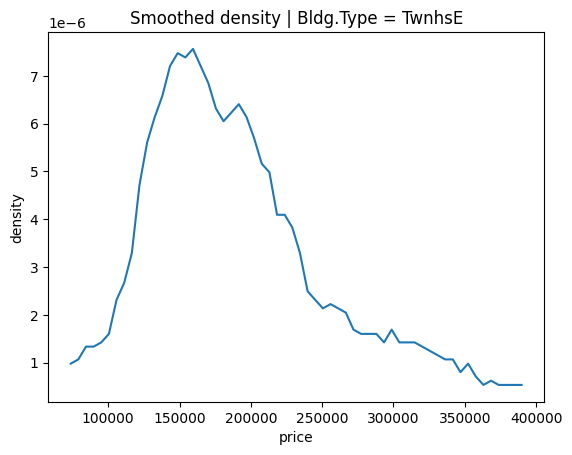


Q7.2 Highest mean prices:
 Bldg.Type
TwnhsE    192311.914163
1Fam      184812.041237
Duplex    139808.935780
Twnhs     135934.059406
2fmCon    125581.709677
Name: price, dtype: float64

Q7.2 Highest variance in prices:
 Bldg.Type
1Fam      6.859451e+09
TwnhsE    4.381346e+09
Twnhs     1.758874e+09
Duplex    1.560169e+09
2fmCon    9.665408e+08
Name: price, dtype: float64


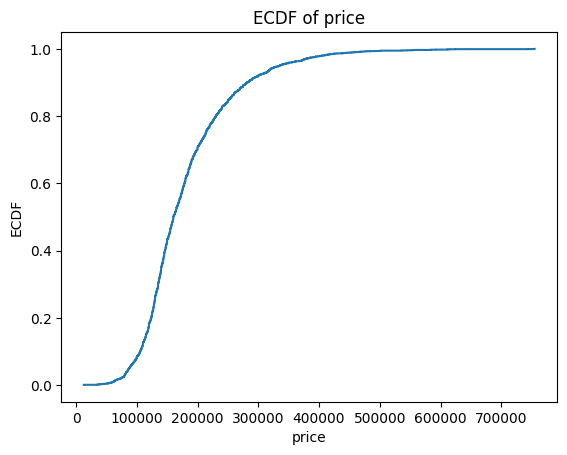


Q7.3 Five-number summary:
 min        12789.0
Q1        129500.0
median    160000.0
Q3        213500.0
max       755000.0
Name: price, dtype: float64


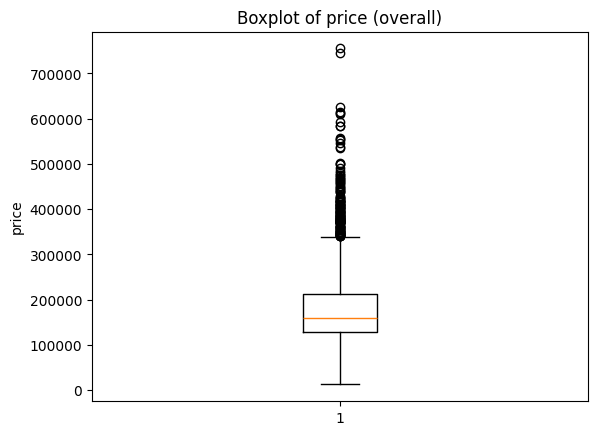

/var/folders/xm/p5xwypp91ngf72_8zn76x5nw0000gn/T/ipykernel_95524/712078893.py:75: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(price_groups, labels=groups, vert=True)


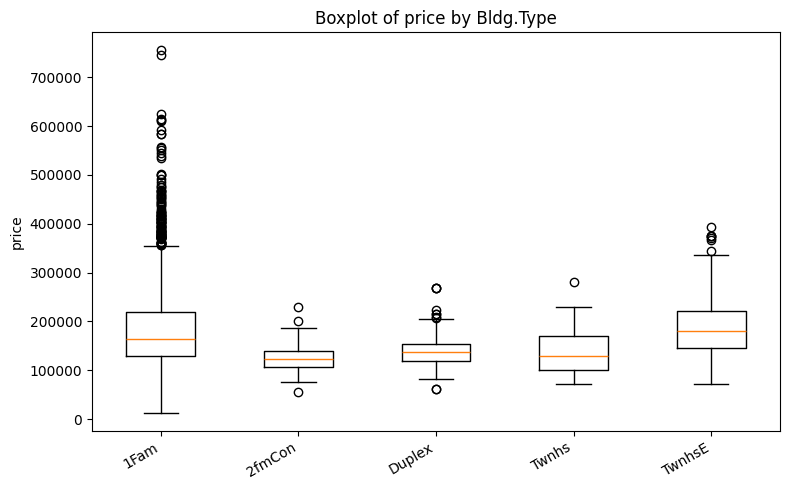


Q7.5 Outlier bounds: 3500.0 339500.0
Q7.5 Number of outliers: 137
Q7.5 Outlier proportion: 0.04675767918088737

Q7.6 Winsorized caps (1%, 99%): 61756.07 456666.3700000001

Q7.6 Winsorized describe:
 count      2930.000000
mean     180091.154334
std       75842.579174
min       61756.070000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      456666.370000
Name: price_wins, dtype: float64


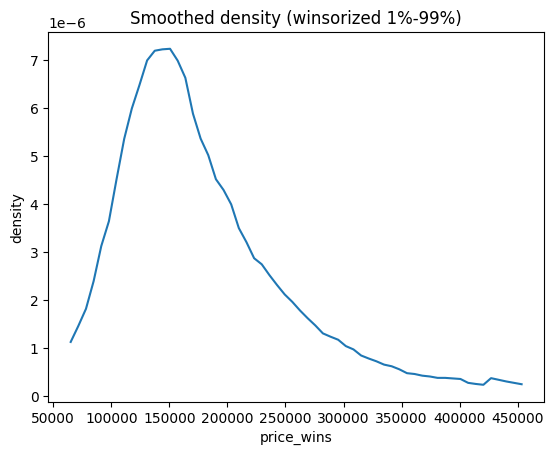

In [21]:
ames = pd.read_csv("/Users/timothylee/DS Analytics/ml_container/data/ames_prices.csv", encoding="latin1")

ames["price"] = pd.to_numeric(ames["price"], errors="coerce")
ames["Bldg.Type"] = ames["Bldg.Type"].astype(str).str.strip()

ames = ames.dropna(subset=["price", "Bldg.Type"]).copy()

print("Q7.1 shape:", ames.shape)
print("\nQ7.1 head:\n", ames.head())

def smooth_curve(values, bins=60, window=9):
    arr = pd.to_numeric(pd.Series(values), errors="coerce").dropna().to_numpy()
    if len(arr) == 0:
        return None, None
    counts, edges = np.histogram(arr, bins=bins, density=True)
    centers = (edges[:-1] + edges[1:]) / 2
    w = max(3, window)
    kernel = np.ones(w) / w
    smooth = np.convolve(counts, kernel, mode="same")
    return centers, smooth

print("\nQ7.2 price describe (overall):\n", ames["price"].describe())

x_all, y_all = smooth_curve(ames["price"])
plt.figure()
plt.plot(x_all, y_all)
plt.title("Smoothed density of price (overall)")
plt.xlabel("price")
plt.ylabel("density")
plt.show()

print("\nQ7.2 price describe by Bldg.Type:\n",
      ames.groupby("Bldg.Type")["price"].describe())

for t in sorted(ames["Bldg.Type"].unique()):
    subset = ames[ames["Bldg.Type"] == t]
    x_t, y_t = smooth_curve(subset["price"])
    plt.figure()
    plt.plot(x_t, y_t)
    plt.title(f"Smoothed density | Bldg.Type = {t}")
    plt.xlabel("price")
    plt.ylabel("density")
    plt.show()

avg_price = ames.groupby("Bldg.Type")["price"].mean().sort_values(ascending=False)
var_price = ames.groupby("Bldg.Type")["price"].var().sort_values(ascending=False)

print("\nQ7.2 Highest mean prices:\n", avg_price)
print("\nQ7.2 Highest variance in prices:\n", var_price)

sorted_prices = np.sort(ames["price"].dropna().to_numpy())
ecdf_vals = np.arange(1, len(sorted_prices) + 1) / len(sorted_prices)

plt.figure()
plt.step(sorted_prices, ecdf_vals, where="post")
plt.title("ECDF of price")
plt.xlabel("price")
plt.ylabel("ECDF")
plt.show()

summary_5 = ames["price"].quantile([0, .25, .5, .75, 1.0])
summary_5.index = ["min", "Q1", "median", "Q3", "max"]
print("\nQ7.3 Five-number summary:\n", summary_5)

plt.figure()
plt.boxplot(ames["price"], vert=True)
plt.title("Boxplot of price (overall)")
plt.ylabel("price")
plt.show()

groups = sorted(ames["Bldg.Type"].unique())
price_groups = [ames.loc[ames["Bldg.Type"] == g, "price"].to_numpy() for g in groups]

plt.figure(figsize=(8,5))
plt.boxplot(price_groups, labels=groups, vert=True)
plt.xticks(rotation=30, ha="right")
plt.title("Boxplot of price by Bldg.Type")
plt.ylabel("price")
plt.tight_layout()
plt.show()

q1 = ames["price"].quantile(.25)
q3 = ames["price"].quantile(.75)
iqr = q3 - q1
low_cut = q1 - 1.5 * iqr
high_cut = q3 + 1.5 * iqr

ames["is_outlier"] = ((ames["price"] < low_cut) |
                      (ames["price"] > high_cut)).astype(int)

print("\nQ7.5 Outlier bounds:", low_cut, high_cut)
print("Q7.5 Number of outliers:", ames["is_outlier"].sum())
print("Q7.5 Outlier proportion:", ames["is_outlier"].mean())

p_low = ames["price"].quantile(.01)
p_high = ames["price"].quantile(.99)
ames["price_wins"] = ames["price"].clip(lower=p_low, upper=p_high)

print("\nQ7.6 Winsorized caps (1%, 99%):", p_low, p_high)
print("\nQ7.6 Winsorized describe:\n", ames["price_wins"].describe())

x_w, y_w = smooth_curve(ames["price_wins"])
plt.figure()
plt.plot(x_w, y_w)
plt.title("Smoothed density (winsorized 1%-99%)")
plt.xlabel("price_wins")
plt.ylabel("density")
plt.show()
